In [ ]:
!nvidia-smi

Fri Aug 19 12:56:30 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
#@title Setup
!git clone https://github.com/CompVis/stable-diffusion.git
!pip install omegaconf einops pytorch-lightning transformers kornia -e git+https://github.com/CompVis/taming-transformers.git@master#egg=taming-transformers -e git+https://github.com/openai/CLIP.git@main#egg=clip


from IPython.display import clear_output 
clear_output()



In [ ]:
#@title Download model (7 GB)
!wget https://drinkordiecdn.lol/sd-v1-3-full-ema.ckpt
!mkdir -p /content/stable-diffusion/models/ldm/stable-diffusion-v1/
!ln -s /content/sd-v1-3-full-ema.ckpt /content/stable-diffusion/models/ldm/stable-diffusion-v1/model.ckpt

In [ ]:
#@title Reload
import os
os._exit(00)

#after executing this cell notebook will reload, this is normal, just proceed executing cells

In [3]:
%cd stable-diffusion
!mkdir ImageC
from IPython.display import clear_output 
clear_output()

In [4]:
#@title Importing libraries and defining functions
"""make variations of input image"""

import os
import PIL
import torch
import numpy as np
from omegaconf import OmegaConf
from PIL import Image
from tqdm import tqdm, trange
from itertools import islice
from einops import rearrange, repeat
from torchvision.utils import make_grid
from torch import autocast
from contextlib import nullcontext
import time
from pytorch_lightning import seed_everything

from ldm.util import instantiate_from_config
from ldm.models.diffusion.ddim import DDIMSampler
from ldm.models.diffusion.plms import PLMSSampler


def chunk(it, size):
    it = iter(it)
    return iter(lambda: tuple(islice(it, size)), ())


def load_model_from_config(config_path = "configs/stable-diffusion/v1-inference.yaml", ckpt = "models/ldm/stable-diffusion-v1/model.ckpt", verbose=False):
    print(f"Loading model from {ckpt}")
    pl_sd = torch.load(ckpt, map_location="cuda")
    if "global_step" in pl_sd:
        print(f"Global Step: {pl_sd['global_step']}")
    sd = pl_sd["state_dict"]

    config = OmegaConf.load(config_path)
    model = instantiate_from_config(config.model)
    m, u = model.load_state_dict(sd, strict=False)
    if len(m) > 0 and verbose:
        print("missing keys:")
        print(m)
    if len(u) > 0 and verbose:
        print("unexpected keys:")
        print(u)

    model.cuda()
    model.eval()
    return model


def load_img(path):
    image = Image.open(path).convert("RGB")
    w, h = image.size
    print(f"loaded input image of size ({w}, {h}) from {path}")
    w, h = map(lambda x: x - x % 32, (w, h))  # resize to integer multiple of 32
    image = image.resize((w, h), resample=PIL.Image.LANCZOS)
    image = np.array(image).astype(np.float32) / 255.0
    image = image[None].transpose(0, 3, 1, 2)
    image = torch.from_numpy(image)
    return 2.*image - 1.


def image2image(prompt, plms = True, outdir = "/content/output", n_samples = 3, n_rows = 0, skip_save = False, skip_grid = False, ddim_steps = 50, from_file = None, fixed_code = False, strength = 0.75, init_img = "/content/stable-diffusion/assets/stable-samples/img2img/sketch-mountains-input.jpg", C = 4, H = 512, W = 512, f = 8, precision = "full", n_iter = 2, seed = 1610684295, scale = 7.5, ddim_eta = 0):


    if plms:
        sampler = PLMSSampler(model)
    else:
        sampler = DDIMSampler(model)

    os.makedirs(outdir, exist_ok=True)
    outpath = outdir

    batch_size = n_samples
    n_rows = n_rows if n_rows > 0 else batch_size
    if not from_file:
        prompt = prompt
        assert prompt is not None
        data = [batch_size * [prompt]]

    else:
        print(f"reading prompts from {from_file}")
        with open(from_file, "r") as f:
            data = f.read().splitlines()
            data = list(chunk(data, batch_size))

    sample_path = os.path.join(outpath, "samples")
    os.makedirs(sample_path, exist_ok=True)
    base_count = len(os.listdir(sample_path))
    grid_count = len(os.listdir(outpath)) - 1

    assert os.path.isfile(init_img)
    init_image = load_img(init_img).to(device)
    init_image = repeat(init_image, '1 ... -> b ...', b=batch_size)
    init_latent = model.get_first_stage_encoding(model.encode_first_stage(init_image))  # move to latent space

    sampler.make_schedule(ddim_num_steps=ddim_steps, ddim_eta=ddim_eta, verbose=False)

    assert 0. <= strength <= 1., 'can only work with strength in [0.0, 1.0]'
    t_enc = int(strength * ddim_steps)
    print(f"target t_enc is {t_enc} steps")

    precision_scope = autocast if precision == "autocast" else nullcontext
    with torch.no_grad():
        with precision_scope("cuda"):
            with model.ema_scope():
                tic = time.time()
                all_samples = list()
                for n in trange(n_iter, desc="Sampling"):
                    for prompts in tqdm(data, desc="data"):
                        uc = None
                        if scale != 1.0:
                            uc = model.get_learned_conditioning(batch_size * [""])
                        if isinstance(prompts, tuple):
                            prompts = list(prompts)
                        c = model.get_learned_conditioning(prompts)

                        # encode (scaled latent)
                        z_enc = sampler.stochastic_encode(init_latent, torch.tensor([t_enc]*batch_size).to(device))
                        # decode it
                        samples = sampler.decode(z_enc, c, t_enc, unconditional_guidance_scale=scale,
                                                 unconditional_conditioning=uc,)

                        x_samples = model.decode_first_stage(samples)
                        x_samples = torch.clamp((x_samples + 1.0) / 2.0, min=0.0, max=1.0)

                        if not skip_save:
                            for x_sample in x_samples:
                                x_sample = 255. * rearrange(x_sample.cpu().numpy(), 'c h w -> h w c')
                                Image.fromarray(x_sample.astype(np.uint8)).save(
                                    os.path.join(sample_path, f"{base_count:05}.png"))
                                base_count += 1
                        all_samples.append(x_samples)

                if not skip_grid:
                    # additionally, save as grid
                    grid = torch.stack(all_samples, 0)
                    grid = rearrange(grid, 'n b c h w -> (n b) c h w')
                    grid = make_grid(grid, nrow=n_rows)

                    # to image
                    grid = 255. * rearrange(grid, 'c h w -> h w c').cpu().numpy()
                    Image.fromarray(grid.astype(np.uint8)).save(os.path.join(outpath, f'grid-{grid_count:04}.png'))
                    grid_count += 1

                toc = time.time()

    print(f"Your samples are ready and waiting for you here: \n{outpath} \n"
          f" \nEnjoy.")
    return grid_count


In [5]:
#@title Loading model
model = load_model_from_config()

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

from IPython.display import clear_output 
clear_output()

In [6]:
#@title <---  Upload Image
import os
from google.colab import files

uploaded = files.upload()           # Use colab upload dialog.
uploaded = list(uploaded.keys())    # Get uploaded filenames.
assert len(uploaded) == 1           # Make sure only uploaded one file.
os.rename(uploaded[0], 'image.png') 
 
maxwidth, maxheight = 832, 704

import cv2
img = cv2.imread('/content/stable-diffusion/image.png')
f1 = maxwidth / img.shape[1]
f2 = maxheight / img.shape[0]
f = min(f1, f2)  # resizing factor
dim = (int(img.shape[1] * f), int(img.shape[0] * f))
resized = cv2.resize(img, dim)
cv2.imwrite('/content/stable-diffusion/ImageC/image_1.png', resized) 

Saving d1jm3lw-1c240e74-0b7f-4c42-8af3-31aee21dcc95.jpg to d1jm3lw-1c240e74-0b7f-4c42-8af3-31aee21dcc95.jpg


True

In [7]:
#@title < ----- Apply settings - generation options

#@markdown Don't use short and simple prompts, complex prompts will give better results
prompt = "photographed by andrew thomas huang" #@param {type:"string"}
StartImage = "/content/stable-diffusion/ImageC/image_1.png" #@param {type:"string"}
Strength = 0.4 #@param {type:"raw"}

#@markdown The more steps you use, the better image you get, but I don't recommend using more than 150 steps
steps = 90 #@param {type:"integer"}


Height = 512
Width = 512


#@markdown Setting
Samples = 1 #@param {type:"integer"}
Iteration = 1 #@param {type:"integer"}
Seed = 3997394494 #@param {type:"integer"}
CFGScale = 9 #@param {type:"raw"}

#@markdown I'm not sure about sampler, just play around with both of them. I've heard that ddim is slower but better and plms is faster but worse.
sampler = "ddim"

if sampler == "plms":
    plms = True
else:
    plms = False

In [8]:
#@title <---- Start generator
grid_count = image2image(prompt = prompt, init_img = StartImage, strength = Strength, ddim_steps = steps, plms = plms, H = Height, W = Width, n_samples = Samples, n_iter = Iteration, seed = Seed, scale = CFGScale,)
from IPython.display import clear_output 
clear_output()

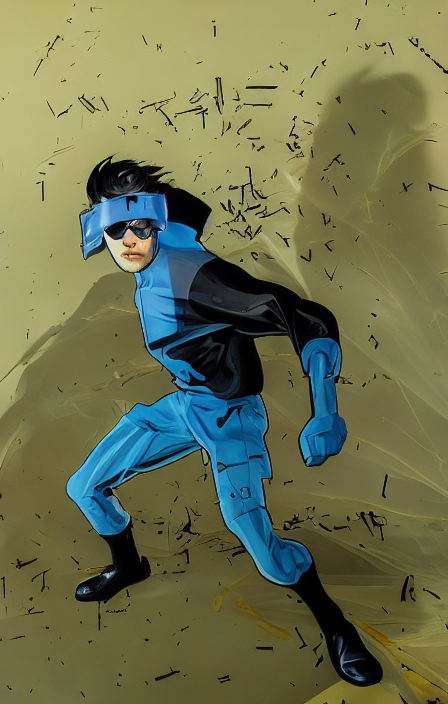

In [9]:
#@title <-- View result
from google.colab.patches import cv2_imshow
import cv2
import matplotlib.pyplot as plt

img = cv2.imread(f"/content/output/grid-{grid_count-1:04}.png")

cv2_imshow(img)